In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx 
import osmnx as ox
import numpy as np

from geopy.distance import great_circle

pd.set_option('display.max_columns', None)

In [2]:
G_road = nx.read_gpickle('.../mfreight/Multimodal/data/road_G.plk')

G_rail = nx.read_gpickle('.../mfreight/Multimodal/data/rail_G.plk')

In [3]:
road_nodes,road_edges = ox.graph_to_gdfs(G_road)

rail_nodes,rail_edges = ox.graph_to_gdfs(G_rail)

In [4]:
road_edges.head(2)

,STATUS,trans_mode,length,duration_h,CO2_eq_kg,geometry,u,v,key
0,1,road,498.0,0.004407,0.040095,"LINESTRING (-81.82870 27.89680, -81.82940 27.9...",1000005067,1000005073,0
1,1,road,987.0,0.008735,0.079466,"LINESTRING (-81.82870 27.89680, -81.82070 27.9...",1000005067,1000005095,0


In [5]:
road_nodes.head(2)

,trans_mode,x,y,osmid,geometry,key
1000005067,road,-81.8287,27.8968,"(-81.8287, 27.8968)",POINT (-81.82870 27.89680),0
1000001719,road,-84.5659,30.9138,"(-84.5659, 30.9138)",POINT (-84.56590 30.91380),0


In [6]:
road_edges.head(2)

,STATUS,trans_mode,length,duration_h,CO2_eq_kg,geometry,u,v,key
0,1,road,498.0,0.004407,0.040095,"LINESTRING (-81.82870 27.89680, -81.82940 27.9...",1000005067,1000005073,0
1,1,road,987.0,0.008735,0.079466,"LINESTRING (-81.82870 27.89680, -81.82070 27.9...",1000005067,1000005095,0


In [7]:
rail_edges.head(2)

,OBJECTID,FRAARCID,STFIPS,RROWNER1,TRACKS,DIRECTION,NET,TIMEZONE,trans_mode,length,CO2_eq_kg,speed_kmh,duration_h,geometry,STRACNET,IM_RT_TYPE,DS,TRKRGHTS1,PASSNGR,TRKRGHTS2,TRKRGHTS3,u,v,key
0,178376,476815,01,AGR,1,2.0,M,C,rail,3085.42343,0.060244,16,0.133893,"LINESTRING (-87.49830 30.99790, -87.49700 31.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,416132,416144,0
1,"[178170, 178171, 178173, 178166]","[476609, 476610, 476612, 476605]",12,AGR,1,2.0,M,C,rail,37397.95557,0.730210,16,21.500911,"LINESTRING (-87.43640 30.68880, -87.50610 30.8...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,416132,416709,0


In [8]:
rail_nodes[rail_nodes.trans_mode == 'intermodal']

,FRANODEID,STATE,STCYFIPS,geometry,trans_mode,key,x,y
170,170,FL,12057,POINT (-82.38160 27.96130),intermodal,0,-82.3816,27.9613
84,84,FL,12031,POINT (-81.76890 30.38540),intermodal,0,-81.7689,30.3854
85,85,FL,12031,POINT (-81.73200 30.36960),intermodal,0,-81.7320,30.3696
179,179,FL,12105,POINT (-81.68270 27.93100),intermodal,0,-81.6827,27.9310
86,86,FL,12031,POINT (-81.61360 30.25550),intermodal,0,-81.6136,30.2555
87,87,FL,12031,POINT (-81.55910 30.39460),intermodal,0,-81.5591,30.3946
44,44,FL,12009,POINT (-80.73150 28.34970),intermodal,0,-80.7315,28.3497
69,69,FL,12111,POINT (-80.32400 27.44500),intermodal,0,-80.3240,27.4450
117,117,FL,12086,POINT (-80.30950 25.83220),intermodal,0,-80.3095,25.8322
118,118,FL,12086,POINT (-80.17410 25.77530),intermodal,0,-80.1741,25.7753


It can be observed that the columns `RROWNER2`, `TRKRGHTS4` have been removed. This is because all their values were null (only florida)

In [9]:
import time

def map_intermodal_to_road(road_nodes,rail_nodes):
    
    intermodal_rail_nodes = rail_nodes[rail_nodes.trans_mode == 'intermodal']

    df = pd.DataFrame(index = intermodal_rail_nodes.index,columns=['road_idx','dist'])
    df2 = pd.DataFrame(index = intermodal_rail_nodes.index,columns=['road_idx','dist'])
    
    start = time.time()
    for row in intermodal_rail_nodes.itertuples():
        dist = pd.eval('(road_nodes.x-row.x)**2 + (road_nodes.y-row.y)**2')
        df.loc[row.Index,'road_idx'] = dist.idxmin()
        df.loc[row.Index,'dist'] = great_circle((row.y,row.x),(road_nodes.loc[dist.idxmin(),'y'],road_nodes.loc[dist.idxmin(),'x'])).km * 1000
    
    print(f'time elapsed {time.time() - start}')
          
    start = time.time()      
    road_idx = []
    dist_to_intermodal = []
    
    for row in intermodal_rail_nodes.itertuples():
        dist = pd.eval('(road_nodes.x-row.x)**2 + (road_nodes.y-row.y)**2')
        road_idx.append(dist.idxmin())
        dist_to_intermodal.append(round(great_circle((row.y,row.x),(road_nodes.loc[dist.idxmin(),'y'],road_nodes.loc[dist.idxmin(),'x'])).km * 1000,2))
    
    df2['road_idx'] = road_idx
    df2['dist'] = dist_to_intermodal
          
    return df, df2

intermodal_to_road_map, df2 = map_intermodal_to_road(road_nodes,rail_nodes)

intermodal_to_road_map.head(3)

time elapsed 0.052655935287475586


,road_idx,dist
170,1000014980,595.926
84,1000013829,1523.16
85,1000014153,860.545


In [10]:
intermodal_links = pd.DataFrame(index = range(len(intermodal_to_road_map)),columns=road_edges.columns)
kg_co2_per_tkm=0.080513
    
intermodal_links['u'] = intermodal_to_road_map.road_idx.values
intermodal_links['v'] = intermodal_to_road_map.index.values
intermodal_links['length'] = intermodal_to_road_map.dist.values
intermodal_links['speed_kmh'] = 10 #DEFAULT
intermodal_links['duration_h'] = 2 #TODO refine default value
intermodal_links['CO2_eq_kg'] = intermodal_links['length']/1000 * kg_co2_per_tkm
intermodal_links['key'] = 0
intermodal_links['trans_mode'] = 'intermodal_link'

    
intermodal_links

,STATUS,trans_mode,length,duration_h,CO2_eq_kg,geometry,u,v,key,speed_kmh
0,NaN,intermodal_link,595.926,2,0.0479798,NaN,1000014980,170,0,10
1,NaN,intermodal_link,1523.16,2,0.122634,NaN,1000013829,84,0,10
2,NaN,intermodal_link,860.545,2,0.0692851,NaN,1000014153,85,0,10
3,NaN,intermodal_link,4811.03,2,0.387351,NaN,1000009308,179,0,10
4,NaN,intermodal_link,1275.98,2,0.102733,NaN,1000014105,86,0,10
5,NaN,intermodal_link,1952.73,2,0.15722,NaN,1000014738,87,0,10
6,NaN,intermodal_link,675.798,2,0.0544105,NaN,1000012386,44,0,10
7,NaN,intermodal_link,266.246,2,0.0214363,NaN,1000015095,69,0,10
8,NaN,intermodal_link,857.137,2,0.0690107,NaN,1000007076,117,0,10
9,NaN,intermodal_link,309.188,2,0.0248937,NaN,1000015019,118,0,10


In [11]:
road_edges = road_edges.append(intermodal_links,ignore_index=True)

In [12]:
intermodal_nodes = pd.DataFrame(index = intermodal_to_road_map.index,columns=road_nodes.columns)

x,y,geometry,STCYFIPS=[],[],[],[]

for row in intermodal_to_road_map.itertuples():
    x.append(rail_nodes.loc[row.Index,'x'])
    y.append(rail_nodes.loc[row.Index,'y'])
    geometry.append(rail_nodes.loc[row.Index,'geometry'])
    STCYFIPS.append(rail_nodes.loc[row.Index,'STCYFIPS'])
    
intermodal_nodes['x'] = x
intermodal_nodes['y'] = y
intermodal_nodes['geometry'] = geometry
intermodal_nodes['STCYFIPS'] = STCYFIPS
intermodal_nodes['trans_mode'] = 'intermodal'
intermodal_nodes['key'] = 0

In [13]:
intermodal_nodes

,trans_mode,x,y,osmid,geometry,key,STCYFIPS
170,intermodal,-82.3816,27.9613,NaN,POINT (-82.38160000000001 27.9613),0,12057
84,intermodal,-81.7689,30.3854,NaN,POINT (-81.7689 30.3854),0,12031
85,intermodal,-81.7320,30.3696,NaN,POINT (-81.732 30.3696),0,12031
179,intermodal,-81.6827,27.9310,NaN,POINT (-81.6827 27.931),0,12105
86,intermodal,-81.6136,30.2555,NaN,POINT (-81.61360000000001 30.2555),0,12031
87,intermodal,-81.5591,30.3946,NaN,POINT (-81.5591 30.3946),0,12031
44,intermodal,-80.7315,28.3497,NaN,POINT (-80.7315 28.3497),0,12009
69,intermodal,-80.3240,27.4450,NaN,POINT (-80.324 27.445),0,12111
117,intermodal,-80.3095,25.8322,NaN,POINT (-80.3095 25.8322),0,12086
118,intermodal,-80.1741,25.7753,NaN,POINT (-80.1741 25.7753),0,12086


In [14]:
road_nodes  = road_nodes.append(intermodal_nodes)

In [15]:
G_road_w_link = ox.graph_from_gdfs(road_nodes, road_edges)

In [16]:
multimodal_net = nx.compose(G_road_w_link,G_rail)

In [17]:
nodes, edges = ox.graph_to_gdfs(multimodal_net)

In [18]:
nodes.loc[68,:]

trans_mode                           intermodal
x                                      -80.1299
y                                        26.082
osmid                                       NaN
geometry      POINT (-80.12990000000001 26.082)
key                                           0
STCYFIPS                                  12011
FRANODEID                                    68
STATE                                        FL
Name: 68, dtype: object

Text(0.5, 1.0, 'connected components size')

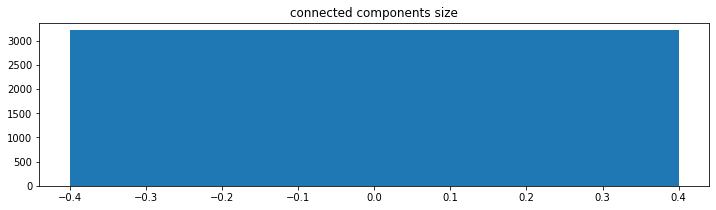

In [19]:
import matplotlib.pyplot as plt
multimodal_net_u = multimodal_net.to_undirected()

component_size = sorted([len(component) for component in nx.connected_components(multimodal_net_u)], reverse=True)
fig, ax = plt.subplots(figsize=(12,3))
plt.bar(range(len(component_size)),component_size)
plt.plot(range(len(component_size)),component_size,color='red',alpha=0.5)
plt.title('connected components size')

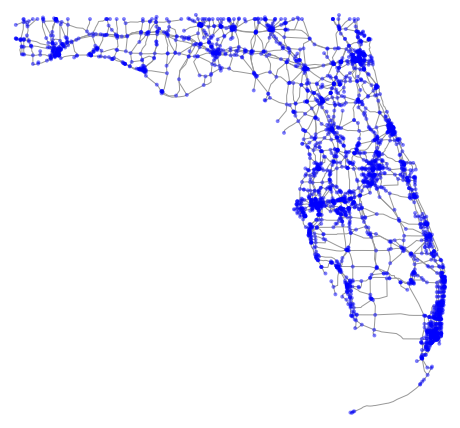

In [20]:
fig, ax = ox.plot_graph(multimodal_net_u,node_color='blue',bgcolor='white',node_alpha=0.5)

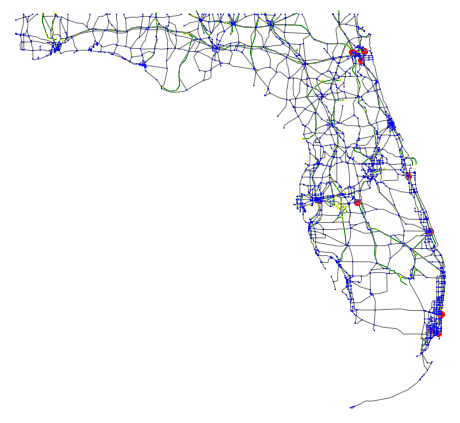

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [21]:
fig, ax = ox.plot_graph(G_rail,edge_color="green",node_color='yellow',bgcolor='white',node_size=2, node_alpha=0.9,show=False)
rail_nodes[rail_nodes.trans_mode == 'intermodal'].plot(ax=ax, color='red')
ox.plot_graph(G_road_w_link,edge_color="grey", node_color='blue',bgcolor='white', node_size=2, node_alpha=0.9,show=True,ax=ax)

# Routing

In [22]:
def get_route(G,orig,dest,weight='duration_h',orig_dest_size=100,algo='astar'):
    
    node_orig,dist_orig = ox.distance.get_nearest_node(G, orig, method='haversine', return_dist=True)
    node_dest,dist_dest = ox.distance.get_nearest_node(G, dest, method='haversine', return_dist=True)
    
    if algo == 'astar':
        dist_path = nx.astar_path_length(G, node_orig, node_dest, weight='length')
        weight_path = nx.astar_path_length(G, node_orig, node_dest, weight=weight)
        shortest_path_nx = nx.astar_path(G, node_orig, node_dest, weight=weight)
        
    elif algo == 'dijkstra':
        dist_path = nx.dijkstra_path_length(G, node_orig, node_dest, weight='length')
        weight_path = nx.dijkstra_path_length(G, node_orig, node_dest, weight=weight)
        shortest_path_nx = nx.dijkstra_path(G, node_orig, node_dest, weight=weight)
        
    else:
        raise AssertionError(f'The parameter "algo" can either be "astar" or "dijkstra", not {algo}')
    
    distance_highway = dist_path
    
    dist_non_highway = dist_orig + dist_dest
    
    total_dist =  dist_non_highway + distance_highway
    
    fig, ax = plt.subplots(figsize=(15, 7))
   
    ax.scatter(orig[1],orig[0],marker='x',s=orig_dest_size,zorder=5)
    ax.scatter(dest[1],dest[0],marker='x',s=orig_dest_size,zorder=10)
    ox.plot_graph(G, edge_color="#bfbfbf", node_color="#595959",bgcolor="w",ax=ax, show=False)
    ox.plot.plot_graph_route(G, shortest_path_nx, route_color='g', route_linewidth=4, route_alpha=0.9, orig_dest_size=100,ax=ax)
    
    if weight=='length':
        
        print(f'Distance {dist_path/1000} [km]')
        
    elif weight=='duration_h':
        if dist_path>1:
            print(f'Duration {weight_path} [h] \nDistance {total_dist/1000} [km]')
            
        else:
            print(f'Duration {weight_path*60} [min] \nDistance {total_dist/1000} [km]')
            
    elif weight=='CO2_eq_kg':
        print(f'{str(weight)}: {weight_path} \nDistance {total_dist/1000} [km]')
    
    else:
        print(f'{str(weight)}: {dist_path/1000}')
        
    return node_orig, node_dest

In [23]:
def _weight_function(G, weight):
    return lambda data: data.get(weight, 0)

def get_mode_details(G,w_target,orig,dest):
    node_orig, dist_orig = ox.distance.get_nearest_node(G, orig, method='haversine', return_dist=True)
    node_dest, dist_dest = ox.distance.get_nearest_node(G, dest, method='haversine', return_dist=True)
    shortest_path_nx = nx.astar_path(multimodal_net_u, node_orig, node_dest, weight=w_target)
    
    return get_route_detail(G, shortest_path_nx)

def get_route_detail(G, path, show_breakdown_by_mode = True):
    weights = ['trans_mode','length','CO2_eq_kg','duration_h']
    route_detail = pd.DataFrame(index=range(len(path)-1), columns= weights)
    
    for w in weights:
        weight = _weight_function(G, w)
        route_detail[str(w)] = [weight(G[u][v][0]) for u, v in zip(path[:-1], path[1:])]
    
    route_summary = pd.pivot_table(route_detail, values = ['length','CO2_eq_kg'],index=['trans_mode'], aggfunc=np.sum)
    
    if show_breakdown_by_mode:
        route_summary = route_summary.append(pd.DataFrame(dict(route_summary.sum()),index=['Total']))
    else:
        route_summary = pd.DataFrame(dict(route_summary.sum()),index=['Total'])
    
    return route_summary, list(route_detail.trans_mode).count('intermodal_link')
    

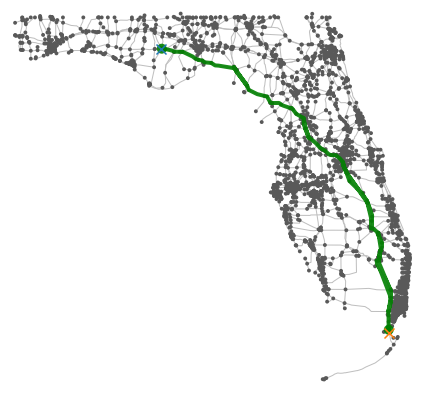

Distance 846.862 [km]


(1000001567, 1000006518)

In [24]:
hwy_dest = (25.382380, -80.475159)
hwy_ori =(30.439440, -85.057166)

get_route(multimodal_net_u,hwy_ori,hwy_dest,weight='length', algo='dijkstra')

In [25]:
route_summary, mode_change_count = get_mode_details(G = multimodal_net_u,
                   w_target = 'CO2_eq_kg',
                   orig = hwy_ori,
                   dest = hwy_dest)

In [26]:
route_summary

,CO2_eq_kg,length
intermodal_link,0.094179,1169.733297
rail,11.038995,565365.894320
road,30.527792,379166.000000
Total,41.660966,945701.627617


In [27]:
mode_change_count

2